# Проект: Samokat.Tech NLP

Вам предлагается решить задачу множественной классификации текстов для определения всех классов, к которым можно отнести каждый экземпляр. В задании представлены ответы на опрос, состоящий из части с выбором ответа из списка и расширенного комментария с произвольным текстом. Необходимо для каждого ответа из 50 различных меток классов выбрать все затронутые.

Метрикой в данной задаче является Accuracy, которая в множественной классификации считается через полное совпадение списка выбранных классов для каждого экземпляра.

In [37]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import tqdm
from tqdm import notebook
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import (
    f1_score, 
    accuracy_score,
    classification_report, 
)

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertConfig
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
RANDOM_STATE = 32
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

sns.set(style='darkgrid', font_scale=1.2)

# Анализ данных

Проанализируем данные. Поищем дупликаты

In [4]:
trends_description = pd.read_csv("trends_description.csv")

In [5]:
trends_description['explanation'].head()

0    - долго везёте\n- очень долго везёте\n- сюда о...
1    - клиент делает акцент на то, что раньше мы до...
2    - клиент акцентирует внимание, что SLA не соот...
3    - клиент акцентриет внимание, что мы часто/каж...
4    - клиент говорит о том, что невозможно понять,...
Name: explanation, dtype: object

In [6]:
df = pd.read_csv("train.csv")

In [7]:
df.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALO...",Доставка просто 👍,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(8708, 54)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708 non-null   int64  
 17  trend_id_res13  8708 non-null   i

In [10]:
np.unique(df['trend_id_res0'])

array([0, 1], dtype=int64)

In [11]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [12]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [13]:
a = 4085 / 8708
a

0.46910886541111624

In [14]:
for i in df.columns[4:54]:
    print('Тематика', i, df[i].value_counts()[1])

Тематика trend_id_res0 837
Тематика trend_id_res1 347
Тематика trend_id_res2 597
Тематика trend_id_res3 361
Тематика trend_id_res4 126
Тематика trend_id_res5 52
Тематика trend_id_res6 21
Тематика trend_id_res7 35
Тематика trend_id_res8 140
Тематика trend_id_res9 10
Тематика trend_id_res10 96
Тематика trend_id_res11 108
Тематика trend_id_res12 624
Тематика trend_id_res13 34
Тематика trend_id_res14 73
Тематика trend_id_res15 81
Тематика trend_id_res16 191
Тематика trend_id_res17 9
Тематика trend_id_res18 231
Тематика trend_id_res19 360
Тематика trend_id_res20 132
Тематика trend_id_res21 99
Тематика trend_id_res22 25
Тематика trend_id_res23 65
Тематика trend_id_res24 10
Тематика trend_id_res25 13
Тематика trend_id_res26 27
Тематика trend_id_res27 530
Тематика trend_id_res28 420
Тематика trend_id_res29 61
Тематика trend_id_res30 306
Тематика trend_id_res31 50
Тематика trend_id_res32 13
Тематика trend_id_res33 28
Тематика trend_id_res34 11
Тематика trend_id_res35 58
Тематика trend_id_res36 

In [15]:
for i in range(len(df['trend_id_res17'])):
    if df.loc[i, 'trend_id_res17'] == 1:
        print(df.loc[i, 'text'])
        print('_'*50)

Видимо везёт сильно мне) но курьеры все какие то странные, все написано в комментариях подробно, они все равно стоят и ждут, а потом ругаются что они долго ждут) научите читать курьеров комментарии
__________________________________________________
Постоянные опозд-я,отсутсв.клиент-ти.На замеч.не класть карт-ку с землей в общий пакет с прод. не реагируют.Кл-ты моют прод-ты от земли. Всем плевать на жалобы,отписки по шаблону.Вкусвилл везёт прод. столько же,цены адекватнее,клиент-ть на высоте.👎🏻👎🏻
__________________________________________________
Я думаю вы компания обманщиков, так как регулярная цена ничем не отличается от цены со скидкой. Вы кого обмануть пытаетесь???? А ещё мне ни разу не привезли сегодняшний хлеб, он всегда вчерашний или позавчерашний даже если я в комментариях прошу об этом.
__________________________________________________
Неудобно следить за доставкой. Время трекера не соответствует реальности. На карте видеть курьера удобнее. Курьеры игнорируют комментарий «ост

In [16]:
trends_description['explanation'][17]

'- клиент жалуется на то, что мы не выполнили комментарий (без кпоминания курьера)\n- если говорят, о том, что курьер не прочитал комментарий —\xa0относим к категории "заменчания по работе курьера"'

In [19]:
df['index'].duplicated().sum()

0

In [91]:
df_zero = df[(df['sum'] == 0)]

In [92]:
df_zero['text'].head()

4                                    Доставка просто 👍
6    Некоторые продукты не очень хорошего качества,...
7                            Слишком часто опаздываете
8                                          Все отлично
9                                 Спасибо, что Вы есть
Name: text, dtype: object

Вывод: На входе имеем датасет из 8708 наблюдений. Внутри есть непосредственно комментарии текстом. Теги отмеченые пользователем при комментировании - их можно будет попробывать использовать при обучении. Разметка состоит из 50 котегорий 0 и 1. Полностью нулевых разметок 4085 из 8708. Эти наблюдения будут сильно мешать обучению, но и убирать их нельзя, так как "пустые" комментарии - неотемлимая часть подобных сервисов. Некоторые тематики имеют очень мало меток: большенство до 50 шт. 46я тематека всего 7 шт. При таком соотношении я считаю, что модели при обучении мудут стремится отметить 'нули' - это видно метрике в baseline (0,500) против полностью нулевых значений (0.4691). В ходе поверхностной проверке разметка сделано адекватна. Однако мною замечены среди "нулевых" разметок информативные комментарие, которые остались без меток. Дупликатов и пропусков нет.

# Обучение моделей и проверка их качества

В этом разделе буду обучать различные модели с разной предобработкой данных. Сравнивать метрику буду с метрикой полученной на baseline (0.50071).

In [333]:
df = pd.read_csv("train.csv")

In [158]:
X, y = df[["text"]], df[[f"trend_id_res{i}" for i in range(50)]]

## Обработка текста 0.49698

Суть гепотезы: попробую улучшить качество с помощью обработки текста: нижний регистр, оставляем только крилицу, удаляем стоп-слова.

In [32]:
corpus = df['text'].values.astype('U')

In [33]:
corpus
len(corpus)

8708

In [34]:
# Функция для предобработки текста.
# 1. Нижней регистр
# 2. Удаляем символы кроме кирилицы
# 3. Удаляем стоп-слова
def preprocess_text(texts):
    stop_words = set(stopwords.words('russian'))
    regex = re.compile('[^а-яА-ЯёЁ ]')
    preprocess_texts = []
    for i in tqdm.tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        preprocess_texts.append(' '.join(filtered_sentence))
    return preprocess_texts

In [44]:
import tqdm
df['preprocess_data'] = preprocess_text(corpus)

100%|████████████████████████████████████████████████████████████████████████████| 8708/8708 [00:00<00:00, 8819.18it/s]


In [45]:
df['preprocess_data'].head()

0    маленький выбор товаров хотелось ассортимент в...
1                                               быстро
2                     доставка постоянно задерживается
3                     наценка ассортимент расстраивают
4                                      доставка просто
Name: preprocess_data, dtype: object

In [159]:
X = X.astype("str").copy()

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 50)
X_test.shape is (1742, 1)
y_test.shape is (1742, 50)


In [161]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [162]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [163]:
cross_valid

{'fit_time': array([8.19608283, 8.18710303, 8.25392413, 8.37160969, 8.32573128]),
 'score_time': array([0.22439575, 0.22739148, 0.20944047, 0.19946694, 0.19846988]),
 'test_accuracy': array([0.4892396 , 0.47666906, 0.51256281, 0.51184494, 0.52692032])}

In [164]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.5034473453555954


In [165]:
y_pred = cross_val_predict(pipeline_multiout, X_train, y_train, cv = 2)
accuracy_score(y_train, y_pred)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.4982773471145564

In [46]:
X, y = df[["preprocess_data"]], df[[f"trend_id_res{i}" for i in range(50)]]

In [47]:
X = X.astype("str").copy()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 50)
X_test.shape is (1742, 1)
y_test.shape is (1742, 50)


In [49]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "preprocess_data")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'preprocess_data')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [50]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [51]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.5014380160692785


In [52]:
y_pred = cross_val_predict(pipeline_multiout, X_train, y_train, cv = 2)
accuracy_score(y_train, y_pred)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.49698535745047373

Вывод: Метрика:0.49698. Метрика слегка ухудшилась. Подобная оброботка не принесла результата.

## Учим 50 моделей по отдельности 0.48692

Суть гепотезы: Учим 50 моделей по отдельности для каждой тематике и использованием мешка слов Tfidf

In [53]:
vectorizer_tf_idf = TfidfVectorizer()

In [54]:
def bow(vectorizer, train, test):
    train_bow = vectorizer.fit_transform(train)
    test_bow = vectorizer.transform(test)
    return train_bow, test_bow

In [57]:
clf = LogisticRegression()
acc = 1
for i in df.columns[4:54]:
    print('Тематика', i, df[df[i] == 0][i].count()/df.shape[0])
    train, test_valid = train_test_split(df,
                                     stratify=df[i],
                                     test_size=0.4,
                                     random_state=RANDOM_STATE)
    valid, test = train_test_split(test_valid,
                               test_size=0.5,
                               random_state=RANDOM_STATE)
    X_train_tfidf, X_valid_tfidf = bow(vectorizer_tf_idf,
                                                         train.text,
                                                         valid.text)
    clf.fit(X_train_tfidf, train[i])
    metr = accuracy_score(valid[i], clf.predict(X_valid_tfidf))
    #print('LogisticRegression: ', metr)
    acc = acc * metr
acc

Тематика trend_id_res0 0.903881488286633
Тематика trend_id_res1 0.9601515847496555
Тематика trend_id_res2 0.9314423518603583
Тематика trend_id_res3 0.9585438677078548
Тематика trend_id_res4 0.9855305466237942
Тематика trend_id_res5 0.9940284795590262
Тематика trend_id_res6 0.997588424437299
Тематика trend_id_res7 0.9959807073954984
Тематика trend_id_res8 0.9839228295819936
Тематика trend_id_res9 0.9988516306844281
Тематика trend_id_res10 0.9889756545705098
Тематика trend_id_res11 0.9875976113918236
Тематика trend_id_res12 0.9283417547083141
Тематика trend_id_res13 0.9960955443270556
Тематика trend_id_res14 0.9916169039963252
Тематика trend_id_res15 0.9906982085438677
Тематика trend_id_res16 0.9780661460725769
Тематика trend_id_res17 0.9989664676159853
Тематика trend_id_res18 0.9734726688102894
Тематика trend_id_res19 0.958658704639412
Тематика trend_id_res20 0.9848415250344511
Тематика trend_id_res21 0.9886311437758383
Тематика trend_id_res22 0.9971290767110703
Тематика trend_id_res23 

0.4869277691170037

Вывод: Общая метрика найденная просто умножением второстепенных: 0.48692

## Используем теги 0.49971

Суть гепотезы: попробую использовать теги отмеченные пользователями. Добавлю в коменнтарий одним словом.

In [58]:
a = df['tags'].unique()
len(a)

1136

In [59]:
ans = []
for i in a:
    ans.append(str(i))

In [60]:
char1 = '{'
res1 = [ele.replace(char1, '') for ele in ans]
char2 = '}'
res2 = [ele.replace(char2, '') for ele in res1]

In [61]:
res3 = []
res3 = ','.join(res2).split(',')

In [62]:
unique_w = list(set(res3))
unique_w

['PROMOTIONS',
 'nan',
 'ASSORTMENT',
 'PRODUCTS_QUALITY',
 'PRICE',
 'DELIVERY',
 'SUPPORT',
 'CATALOG_NAVIGATION',
 'PAYMENT']

In [63]:
df['text'] = df['text'].astype("str").copy()
df['tags'] = df['tags'].astype("str").copy()

In [64]:
df['text_tags'] = df['text']

In [65]:
for i in range(len(df['tags'])):
    if 'PRICE' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' цена'

In [66]:
for i in range(len(df['tags'])):
    if 'ASSORTMENT' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' ассортимент'

In [67]:
for i in range(len(df['tags'])):
    if 'CATALOG_NAVIGATION' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' каталог'

In [68]:
for i in range(len(df['tags'])):
    if 'PAYMENT' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' оплата'

In [69]:
for i in range(len(df['tags'])):
    if 'SUPPORT' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' поддержка'

In [70]:
for i in range(len(df['tags'])):
    if 'PROMOTIONS' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' акции'

In [71]:
for i in range(len(df['tags'])):
    if 'DELIVERY' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' доставка'

In [72]:
for i in range(len(df['tags'])):
    if 'PRODUCTS_QUALITY' in df.loc[i, 'tags']:
        df.loc[i, 'text_tags'] = df.loc[i, 'text_tags'] + ' качество'

In [73]:
X, y = df[["text_tags"]], df[[f"trend_id_res{i}" for i in range(50)]]

In [74]:
X = X.astype("str").copy()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 50)
X_test.shape is (1742, 1)
y_test.shape is (1742, 50)


In [76]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text_tags")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text_tags')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [77]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [78]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.5037354223464113


In [79]:
y_pred = cross_val_predict(pipeline_multiout, X_train, y_train, cv = 2)
accuracy_score(y_train, y_pred)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.4997128911857594

Вывод: Метрика: 0.49971. 

## Убераем "нулевые" 0.20118

Суть гепотезы: попробую обучить модель на данных без "нулевых" разметок

In [80]:
df = pd.read_csv("train.csv")

In [81]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [82]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [83]:
df_filtred = df[(df['sum'] > 0)]

In [84]:
X, y = df_filtred[['text']], df_filtred[[f"trend_id_res{i}" for i in range(50)]]

In [85]:
X = X.astype('str').copy()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (3698, 1)
y_train.shape is (3698, 50)
X_test.shape is (925, 1)
y_test.shape is (925, 50)


In [87]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [88]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [89]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.24202538126760045


In [90]:
y_pred = cross_val_predict(pipeline_multiout, X_train, y_train, cv = 2)
accuracy_score(y_train, y_pred)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.20118983234180637

## 51я тематека 0.35041

Суть гепотезы: добавим 51ю тематека: выделим полностью "нолевую" разметку в одну категорию

In [93]:
df = pd.read_csv("train.csv")

In [94]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [95]:
df['trend_id_res50'] = 0

In [96]:
for i in range(len(df)):
    if df.loc[i, 'sum'] == 0:
        df.loc[i, 'trend_id_res50'] = 1

In [97]:
X, y = df[["text"]], df[[f"trend_id_res{i}" for i in range(51)]]

In [98]:
X = X.astype("str").copy()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 51)
X_test.shape is (1742, 1)
y_test.shape is (1742, 51)


In [100]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [101]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [102]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.36764268153639695


In [103]:
y_pred = cross_val_predict(pipeline_multiout, X_train, y_train, cv = 2)
accuracy_score(y_train, y_pred)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.35041630778064886

Вывод: Метрика 0.35041

## Ансамбль 0.50344

Суть гепотезы: попробую проредить основной датасет с помощью модели логистической регресии для нахождение "нулевых" ноблюдение. Потом учимся класически на прореженных данных. Основную метрику считаю с учетом принудительно "обнуленных" наблюдений выделенных в первом этапе.

In [104]:
df = pd.read_csv("train.csv")

In [105]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [106]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [107]:
df['trend_id_res50'] = 0

In [108]:
for i in range(len(df)):
    if df.loc[i, 'sum'] == 0:
        df.loc[i, 'trend_id_res50'] = 1

In [109]:
X, y = df[["text"]], df[[f"trend_id_res{i}" for i in range(51)]]

In [110]:
X = X.astype("str").copy()

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 51)
X_test.shape is (1742, 1)
y_test.shape is (1742, 51)


In [112]:
y_train_lr = y_train['trend_id_res50']
y_test_lr = y_test['trend_id_res50']

In [113]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_lr = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter = 10_000)),
    ]
)
display(pipeline_lr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf', LogisticRegression(max_iter=10000))])

In [114]:
cross_valid = cross_validate(pipeline_lr, 
                             X_train, y_train_lr, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [115]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.7479170807923611


In [120]:
y_pred_lr = cross_val_predict(pipeline_lr, X_train, y_train_lr, cv = 2)
accuracy_score(y_train_lr, y_pred_lr)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.7469135802469136

In [122]:
index_del = []
for i in range(len(y_pred_lr)):
    if y_pred_lr[i] == 1:
        index_del.append(y_train.index[i])
index_del[:5]

[3589, 395, 4476, 2006, 7053]

In [123]:
len(index_del)

2664

In [124]:
max(index_del)

8706

In [126]:
df_tin = df.drop(index_del)
df_tin['sum'].value_counts()

1    2510
0    2005
2    1103
3     342
4      84
Name: sum, dtype: int64

In [122]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [127]:
X_train_multi = X_train.drop(index_del)
y_train_multi = y_train.drop(index_del)

In [128]:
y_train_multi = y_train_multi.drop('trend_id_res50', axis=1)

In [129]:
print(f"X_train.shape is {X_train_multi.shape}")
print(f"y_train.shape is {y_train_multi.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (4302, 1)
y_train.shape is (4302, 50)
X_test.shape is (1742, 1)
y_test.shape is (1742, 51)


In [130]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_multiout = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", MultiOutputClassifier(LogisticRegression(max_iter = 10_000))),
    ]
)
display(pipeline_multiout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

In [131]:
cross_valid = cross_validate(pipeline_multiout, 
                             X_train_multi, y_train_multi, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [132]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.34054938821813463


In [133]:
y_pred_multi = cross_val_predict(pipeline_multiout, X_train_multi, y_train_multi, cv = 2)
accuracy_score(y_train_multi, y_pred_multi)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.33170618317061834

In [134]:
len(y_pred_multi)

4302

In [135]:
y_pred_multi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [136]:
len(y_pred_lr)

6966

In [137]:
pred_main = pd.DataFrame(y_pred_multi)

In [138]:
def Insert_row_(row_number, df, row_value):
    df1 = df[0:row_number]
    df2 = df[row_number:]
    df1.loc[row_number]=row_value
    df_result = pd.concat([df1, df2])
    df_result.index = [*range(df_result.shape[0])]
    return df_result

In [139]:
row_value = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]

In [140]:
for i in range(len(y_pred_lr)):
    if y_pred_lr[i] == 1:
        pred_main = Insert_row_(i, pred_main, row_value)

In [141]:
y_train_main = y_train.drop('trend_id_res50', axis=1)

In [142]:
pred_main = pred_main.values

In [143]:
pred_main.shape

(6966, 50)

In [144]:
y_train_main.shape

(6966, 50)

In [145]:
accuracy_score(y_train_main, pred_main)

0.5034453057708872

Вывод: Метрика 0.50344. Есть маленкий буст. Мысль верная.

## Ансамбль v 2.0

Суть гепотезы: попробую проредить основной датасет дважды.

In [146]:
df = pd.read_csv("train.csv")

In [147]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [148]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [149]:
df['trend_id_res50'] = 0

In [150]:
for i in range(len(df)):
    if df.loc[i, 'sum'] == 0:
        df.loc[i, 'trend_id_res50'] = 1

In [151]:
X, y = df[["text"]], df[[f"trend_id_res{i}" for i in range(51)]]

In [152]:
X = X.astype("str").copy()

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6966, 1)
y_train.shape is (6966, 51)
X_test.shape is (1742, 1)
y_test.shape is (1742, 51)


In [154]:
y_train_lr = y_train['trend_id_res50']
y_test_lr = y_test['trend_id_res50']

In [155]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_lr = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter = 10_000)),
    ]
)
display(pipeline_lr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf', LogisticRegression(max_iter=10000))])

In [156]:
cross_valid = cross_validate(pipeline_lr, 
                             X_train, y_train_lr, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [157]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.7479170807923611


In [158]:
y_pred_lr = cross_val_predict(pipeline_lr, X_train, y_train_lr, cv = 2)
accuracy_score(y_train_lr, y_pred_lr)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.7469135802469136

In [159]:
index_del = []
for i in range(len(y_pred_lr)):
    if y_pred_lr[i] == 1:
        index_del.append(y_train_lr.index[i])
index_del[:5]

[3589, 395, 4476, 2006, 7053]

In [160]:
len(index_del)

2664

In [161]:
df_tin = df.drop(index_del)

In [162]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [163]:
df_tin['sum'].value_counts()

1    2510
0    2005
2    1103
3     342
4      84
Name: sum, dtype: int64

In [164]:
X_train_lrv2 = X_train.drop(index_del)
y_train_lrv2 = y_train.drop(index_del)

In [165]:
print(f"X_train.shape is {X_train_lrv2.shape}")
print(f"y_train.shape is {y_train_lrv2.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (4302, 1)
y_train.shape is (4302, 51)
X_test.shape is (1742, 1)
y_test.shape is (1742, 51)


In [166]:
y_train_lrv2 = y_train_lrv2['trend_id_res50']

In [167]:
y_train_lrv2.value_counts()

0    3123
1    1179
Name: trend_id_res50, dtype: int64

In [168]:
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range = (1,3)), "text")
    ],                         
    remainder = "passthrough"
)

pipeline_lrv2 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter = 10_000)),
    ]
)
display(pipeline_lrv2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf', LogisticRegression(max_iter=10000))])

In [169]:
cross_valid = cross_validate(pipeline_lrv2, 
                             X_train_lrv2, y_train_lrv2, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [170]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.7252448477973152


In [171]:
y_pred_lrv2 = cross_val_predict(pipeline_lrv2, X_train_lrv2, y_train_lrv2, cv = 2)
accuracy_score(y_train_lrv2, y_pred_lrv2)
# print(classification_report(y_train, y_pred, zero_division = 0))

0.7254765225476523

In [172]:
index_delv2 = []
for i in range(len(y_pred_lrv2)):
    if y_pred_lrv2[i] == 1:
        index_delv2.append(y_train_lrv2.index[i])
index_delv2

[7400, 1494, 3333, 1987]

In [173]:
import numpy
unique, counts = numpy.unique(y_pred_lrv2, return_counts=True)
dict(zip(unique, counts))

{0: 4298, 1: 4}

In [174]:
print(classification_report(y_train_lrv2, y_pred_lrv2, zero_division = 0))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      3123
           1       0.25      0.00      0.00      1179

    accuracy                           0.73      4302
   macro avg       0.49      0.50      0.42      4302
weighted avg       0.60      0.73      0.61      4302



Вывод: второй этап прореживание выявил лишь 4 наблюдения - неэффективен.

## Эмбеддинги DeepPavlov  0.47787

Суть гепотезы: воспользуюсь предобученой моделью DeepPavlov для создание Эмбеддингов

In [175]:
df = pd.read_csv("train.csv")

In [176]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [177]:
tokenized = df['text'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True))

In [178]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [179]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [180]:
# создаем маску для выделения важных токенов
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(8708, 97)


In [181]:
batch_size = 100

In [182]:
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/87 [00:00<?, ?it/s]

In [183]:
features = np.concatenate(embeddings)
display(features.shape)

(8700, 768)

In [184]:
X, y = features, df[[f"trend_id_res{i}" for i in range(50)]]

In [185]:
y = y.iloc[:8700]

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6960, 768)
y_train.shape is (6960, 50)
X_test.shape is (1740, 768)
y_test.shape is (1740, 50)


In [187]:
model = MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000))

In [188]:
cross_valid = cross_validate(model, 
                             X_train, y_train, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [189]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.47959770114942535


In [190]:
y_pred = cross_val_predict(model, X_train, y_train, cv = 2)

In [191]:
# Посмотрим на целевую метрику
accuracy_score(y_train, y_pred)

0.4778735632183908

Вывод: Метрика 0.47787

## DeepPavlov + Ансамбль 

Суть гепотезы: попробую с помощью DeepPavlov Эмбеддинги осуществить прореживание Датасета

In [192]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [193]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [194]:
df['trend_id_res50'] = 0

In [195]:
for i in range(len(df)):
    if df.loc[i, 'sum'] == 0:
        df.loc[i, 'trend_id_res50'] = 1

In [196]:
X, y = features, df[[f"trend_id_res{i}" for i in range(51)]]

In [197]:
y = y.iloc[:8700]

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")

X_train.shape is (6960, 768)
y_train.shape is (6960, 51)
X_test.shape is (1740, 768)
y_test.shape is (1740, 51)


In [199]:
y_train_lr = y_train['trend_id_res50']
y_test_lr = y_test['trend_id_res50']

In [200]:
model_lr = LogisticRegression(max_iter = 10_000)

In [201]:
cross_valid = cross_validate(model_lr, 
                             X_train, y_train_lr, 
                             cv = 5, scoring = ["accuracy"], n_jobs = -1)

In [202]:
print("test_accuracy:", cross_valid["test_accuracy"].mean())

test_accuracy: 0.7119252873563219


Вывод: промежуточная метрика не улучшилась.

## Глубокое обучения с применением эпох

Суть гепоттезы: использую Torch и глубокое обучение для нахождении "нулевых" наблюдений

### 10 эпох

In [207]:
df = pd.read_csv("train.csv")

In [208]:
df['sum'] = df[[f"trend_id_res{i}" for i in range(50)]].sum(axis=1)

In [209]:
df['sum'].value_counts()

0    4085
1    3012
2    1173
3     354
4      84
Name: sum, dtype: int64

In [210]:
df['trend_id_res50'] = 0

In [211]:
for i in range(len(df)):
    if df.loc[i, 'sum'] == 0:
        df.loc[i, 'trend_id_res50'] = 1

In [212]:
X, y = df[["text"]], df[['trend_id_res50']]

In [213]:
X = X.astype("str").copy()

In [216]:
df['seqlen'] = df['text'].apply(lambda x: len(x))
q1 = df['seqlen'].quantile(.05)
q2 = df['seqlen'].quantile(.95)
df = df.loc[(df['seqlen'] > q1) & (df['seqlen'] < q2)]
df['seqlen'].describe()

count    7760.000000
mean       67.012113
std        57.205381
min         6.000000
25%        22.000000
50%        49.000000
75%        95.000000
max       240.000000
Name: seqlen, dtype: float64

In [217]:
df = df.drop(['seqlen'], axis=1)

In [218]:
class VacClass(Dataset):
    def __init__(self, annotations, thr: list):
        self.annotations = annotations
        self.threshold = thr

    def __getitem__(self, idx):
        txt_ = self.annotations['text'].values[idx]
        target = self.annotations['trend_id_res50'].values[idx]
        if target == 0:
            target = 0
        else:
            target = 1
        return [txt_], torch.tensor(target)

    def __len__(self):
        return len(self.annotations)

In [219]:
w = []
for c in df['trend_id_res50'].unique():
    w.append(len(df.loc[df['trend_id_res50'] == c]) / len(df))

weights = torch.FloatTensor(w)
weights

tensor([0.5249, 0.4751])

In [220]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)
SEED = torch.Generator().manual_seed(RANDOM_STATE)
BATCH_SIZE = 100

device: cpu


In [221]:
vac = VacClass(df, [0, 1])
train_ru, valid_ru = torch.utils.data.random_split(vac, [.8, .2], generator=SEED)
train_dataloader_ru = torch.utils.data.DataLoader(train_ru, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_ru = torch.utils.data.DataLoader(valid_ru, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [222]:
class TransformerRegrModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super().__init__()
        self.tr_model = base_transformer_model
        self.num = num_classes

        if self.tr_model not in  ['rubert', 'base']:
            raise Exception('unknown model')
        elif self.tr_model == 'rubert':
            self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
            self.config = BertConfig.from_pretrained("cointegrated/rubert-tiny2", output_hidden_states=True, output_attentions=True)
        elif self.tr_model == 'base':
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base", model_max_length=512)
            self.config = BertConfig.from_pretrained("ai-forever/ruBert-base", output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_config(self.config)
        self.a1 = nn.ReLU()
        self.classifier_1 = nn.Linear(self.model.pooler.dense.out_features, self.num)
        # self.classifier_dropout = nn.Dropout(p=0.2)
        # self.classifier_2 = nn.Linear(128, self.num)

    def forward(self, inputs):
        t = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        tokens = self.tokenizer.convert_ids_to_tokens(t['input_ids'][0])
        model_output = self.model(**{k: v.to(device) for k, v in t.items()})
        attentions = torch.cat(model_output['attentions']).to('cpu')
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        outputs = self.a1(embeddings)
        outputs = self.classifier_1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.a1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.classifier_2(outputs)

        return outputs, tokens, attentions

In [223]:
rubert = TransformerRegrModel('rubert', 2)

In [224]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


tensor([[-0.0590,  0.0137],
        [-0.0599,  0.0123],
        [-0.0590,  0.0149],
        [-0.0589,  0.0121],
        [-0.0588,  0.0118],
        [-0.0592,  0.0145],
        [-0.0602,  0.0134],
        [-0.0590,  0.0116],
        [-0.0592,  0.0135],
        [-0.0589,  0.0119],
        [-0.0585,  0.0146],
        [-0.0593,  0.0122],
        [-0.0586,  0.0110],
        [-0.0591,  0.0117],
        [-0.0593,  0.0110],
        [-0.0610,  0.0149],
        [-0.0584,  0.0127],
        [-0.0597,  0.0119],
        [-0.0575,  0.0133],
        [-0.0573,  0.0133],
        [-0.0577,  0.0136],
        [-0.0583,  0.0125],
        [-0.0569,  0.0131],
        [-0.0588,  0.0133],
        [-0.0578,  0.0116],
        [-0.0589,  0.0114],
        [-0.0599,  0.0126],
        [-0.0597,  0.0115],
        [-0.0590,  0.0113],
        [-0.0592,  0.0113],
        [-0.0568,  0.0106],
        [-0.0578,  0.0108],
        [-0.0604,  0.0136],
        [-0.0589,  0.0131],
        [-0.0581,  0.0116],
        [-0.0593,  0

In [225]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        # inputs = inputs[0].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs, _, _ = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_data += len(inputs[0])

    scheduler_down.step()
    # scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    return train_loss, train_acc, rate

In [226]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs[0].to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _, _ = model(inputs[0])
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_size += len(inputs[0])
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [227]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []
        seqs = []

        for inputs, labels in test_loader:
            labels = labels.to(device)
            model.eval()
            outputs, _, _ = model(inputs[0])
            seqs.extend(inputs[0])
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += len(inputs[0])

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc, seqs

In [228]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

In [229]:
def freeze_model(model):
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
    return model

In [230]:
def train_transformer(train, val, model, epochs, rate, criterion, freeze):
    model_ = copy.copy(model)
    if freeze:
        model_ = freeze_model(model_)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}, learning rate {r}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model_.parameters(), lr=rate)
        # sch = StepLR(opt, step_size=5, gamma=0.1)
        sch_down = StepLR(opt, step_size=25, gamma=0.2)
        sch_up = StepLR(opt, step_size=10, gamma=200)

        val_acc_p = 0

        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model_, train, criterion, opt, sch_down, sch_up)

            val_loss, val_acc = eval_epoch(model_, val, criterion)
            if val_acc > val_acc_p and epoch != 0:
                torch.save(model_.state_dict(), "tiny.pt")
                print(f'save best model for {epoch} epoch')
                val_acc_p = val_acc
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, r=rate))

    return history, model_

In [231]:
bce = nn.CrossEntropyLoss(weight=weights.to(device))
lr = 3e-4

In [233]:
from tqdm import tqdm

In [234]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=10,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:  10%|███████▌                                                                    | 1/10 [00:41<06:10, 41.19s/it]


Epoch 001 train_loss: 0.6398     val_loss 0.5891 train_acc 0.6474 val_acc 0.7294, learning rate 0.0003


epoch:  20%|███████████████▏                                                            | 2/10 [01:23<05:37, 42.13s/it]

save best model for 1 epoch

Epoch 002 train_loss: 0.5544     val_loss 0.5631 train_acc 0.7650 val_acc 0.7448, learning rate 0.0003


epoch:  30%|██████████████████████▊                                                     | 3/10 [02:04<04:50, 41.46s/it]


Epoch 003 train_loss: 0.5151     val_loss 0.5485 train_acc 0.7879 val_acc 0.7448, learning rate 0.0003


epoch:  40%|██████████████████████████████▍                                             | 4/10 [02:44<04:05, 40.90s/it]


Epoch 004 train_loss: 0.4634     val_loss 0.5577 train_acc 0.8231 val_acc 0.7423, learning rate 0.0003


epoch:  50%|██████████████████████████████████████                                      | 5/10 [03:26<03:26, 41.22s/it]


Epoch 005 train_loss: 0.4103     val_loss 0.5973 train_acc 0.8547 val_acc 0.7191, learning rate 0.0003


epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [04:08<02:46, 41.61s/it]


Epoch 006 train_loss: 0.3729     val_loss 0.6046 train_acc 0.8748 val_acc 0.7274, learning rate 0.0003


epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [04:47<02:01, 40.65s/it]


Epoch 007 train_loss: 0.3470     val_loss 0.6620 train_acc 0.8839 val_acc 0.7017, learning rate 0.0003


epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [05:26<01:20, 40.05s/it]


Epoch 008 train_loss: 0.3111     val_loss 0.6982 train_acc 0.9037 val_acc 0.7068, learning rate 0.0003


epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [06:08<00:40, 40.63s/it]


Epoch 009 train_loss: 0.3070     val_loss 0.7386 train_acc 0.9037 val_acc 0.6985, learning rate 0.0003


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [06:47<00:00, 40.75s/it]


Epoch 010 train_loss: 0.2951     val_loss 0.6863 train_acc 0.9085 val_acc 0.7171, learning rate 0.0003


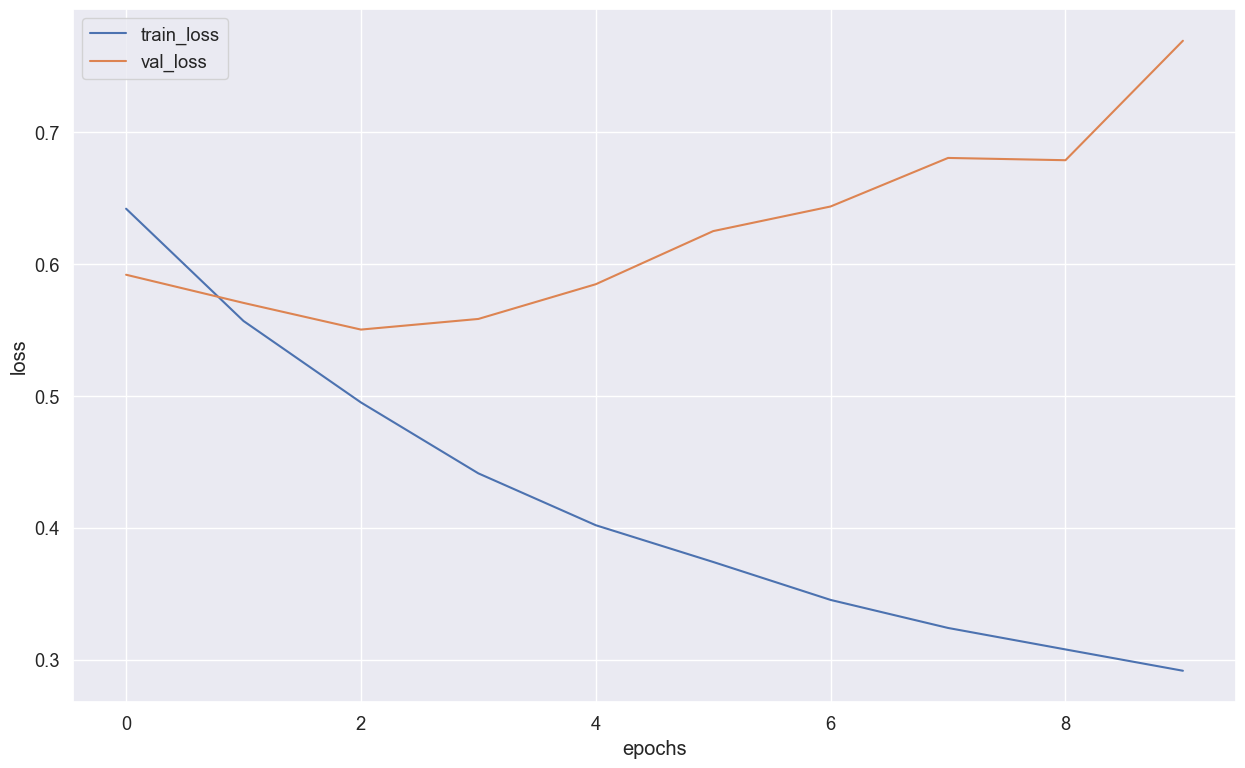

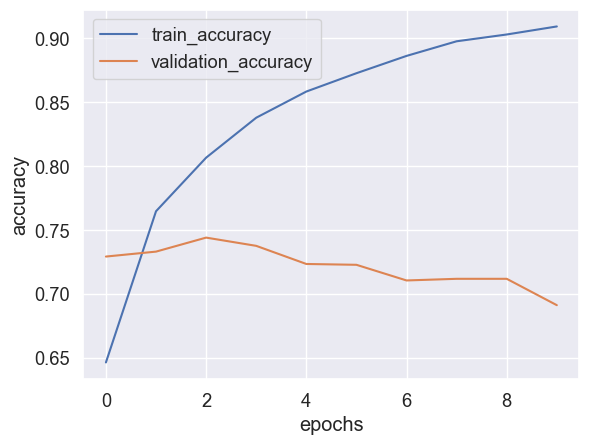

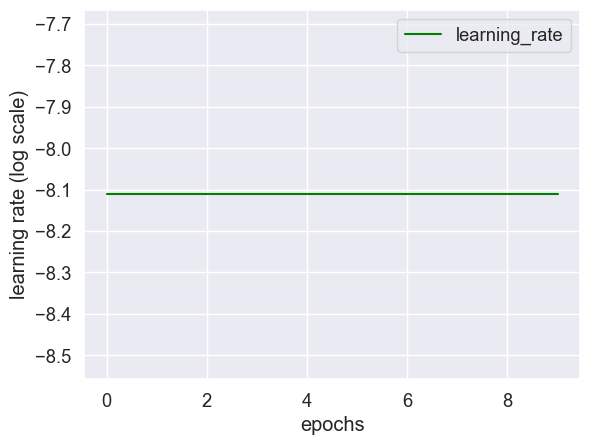

In [349]:
vizualize(graphs, 'RuBert')

In [350]:
tbert = TransformerRegrModel('rubert', 2)
model_path = "tiny.pt"
tbert.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tbert.to(device)
tbert.eval()
result = predict(tbert, valid_dataloader_ru)

In [351]:
CLASSES = {'low': 0,
           'high': 1
}

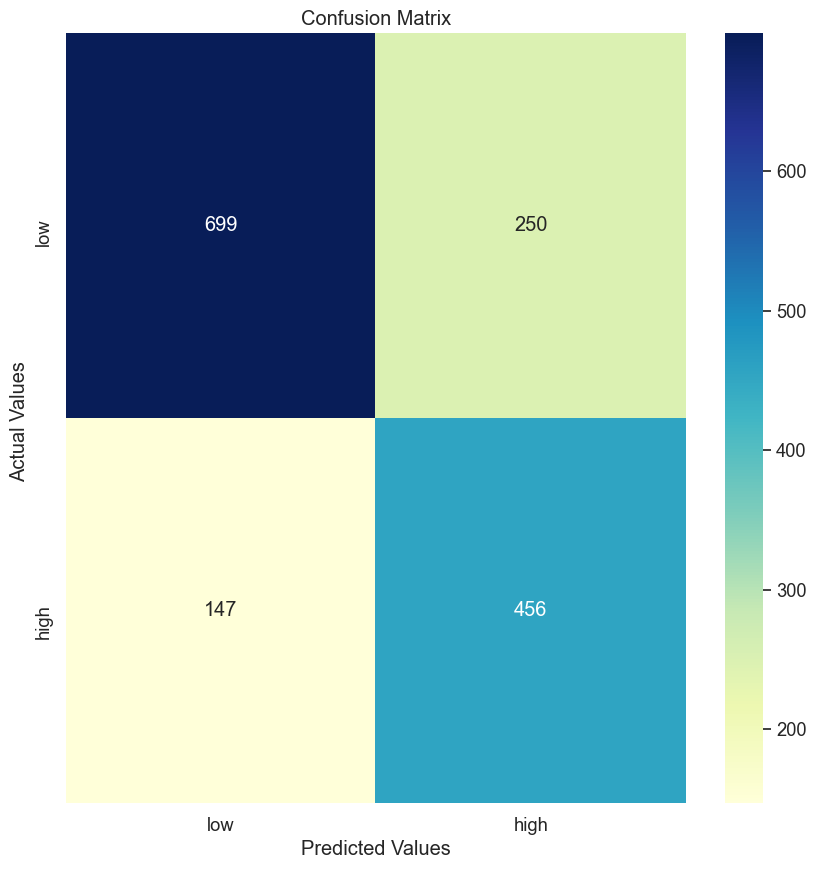

In [352]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(list(CLASSES.keys()))
ax.yaxis.set_ticklabels(list(CLASSES.keys()))
plt.show()

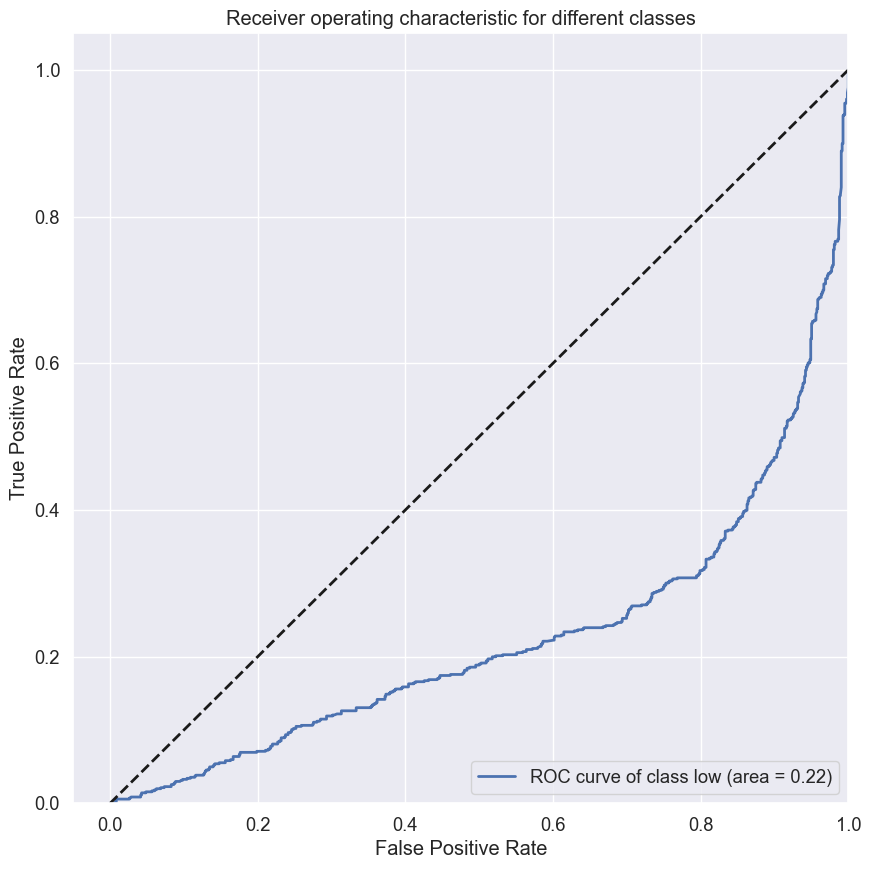

In [353]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

### Torch 30 эпох

In [355]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=30,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:   3%|██▌                                                                         | 1/30 [00:15<07:29, 15.50s/it]


Epoch 001 train_loss: 0.2841     val_loss 0.7938 train_acc 0.9132 val_acc 0.6875, learning rate 0.0003


epoch:   7%|█████                                                                       | 2/30 [00:31<07:21, 15.78s/it]

save best model for 1 epoch

Epoch 002 train_loss: 0.2828     val_loss 0.7934 train_acc 0.9120 val_acc 0.6881, learning rate 0.0003


epoch:  10%|███████▌                                                                    | 3/30 [00:47<07:14, 16.08s/it]

save best model for 2 epoch

Epoch 003 train_loss: 0.2829     val_loss 0.7898 train_acc 0.9122 val_acc 0.6888, learning rate 0.0003


epoch:  13%|██████████▏                                                                 | 4/30 [01:03<06:53, 15.91s/it]


Epoch 004 train_loss: 0.2825     val_loss 0.7892 train_acc 0.9129 val_acc 0.6881, learning rate 0.0003


epoch:  17%|████████████▋                                                               | 5/30 [01:19<06:37, 15.89s/it]


Epoch 005 train_loss: 0.2821     val_loss 0.7869 train_acc 0.9145 val_acc 0.6881, learning rate 0.0003


epoch:  20%|███████████████▏                                                            | 6/30 [01:34<06:18, 15.76s/it]


Epoch 006 train_loss: 0.2828     val_loss 0.7905 train_acc 0.9122 val_acc 0.6881, learning rate 0.0003


epoch:  23%|█████████████████▋                                                          | 7/30 [01:50<06:03, 15.81s/it]


Epoch 007 train_loss: 0.2825     val_loss 0.7853 train_acc 0.9140 val_acc 0.6869, learning rate 0.0003


epoch:  27%|████████████████████▎                                                       | 8/30 [02:06<05:45, 15.72s/it]


Epoch 008 train_loss: 0.2815     val_loss 0.7880 train_acc 0.9143 val_acc 0.6862, learning rate 0.0003


epoch:  30%|██████████████████████▊                                                     | 9/30 [02:22<05:29, 15.71s/it]


Epoch 009 train_loss: 0.2805     val_loss 0.7856 train_acc 0.9156 val_acc 0.6869, learning rate 0.0003


epoch:  33%|█████████████████████████                                                  | 10/30 [02:37<05:12, 15.61s/it]


Epoch 010 train_loss: 0.2806     val_loss 0.7883 train_acc 0.9140 val_acc 0.6875, learning rate 0.0003


epoch:  37%|███████████████████████████▍                                               | 11/30 [02:53<04:57, 15.66s/it]


Epoch 011 train_loss: 0.2797     val_loss 0.7891 train_acc 0.9145 val_acc 0.6875, learning rate 0.0003


epoch:  40%|██████████████████████████████                                             | 12/30 [03:09<04:42, 15.72s/it]

save best model for 11 epoch

Epoch 012 train_loss: 0.2800     val_loss 0.7898 train_acc 0.9140 val_acc 0.6894, learning rate 0.0003


epoch:  43%|████████████████████████████████▌                                          | 13/30 [03:25<04:28, 15.81s/it]

save best model for 12 epoch

Epoch 013 train_loss: 0.2810     val_loss 0.7870 train_acc 0.9137 val_acc 0.6901, learning rate 0.0003


epoch:  47%|███████████████████████████████████                                        | 14/30 [03:41<04:15, 15.94s/it]

save best model for 13 epoch

Epoch 014 train_loss: 0.2795     val_loss 0.7898 train_acc 0.9149 val_acc 0.6914, learning rate 0.0003


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [03:56<03:57, 15.83s/it]


Epoch 015 train_loss: 0.2799     val_loss 0.7843 train_acc 0.9141 val_acc 0.6914, learning rate 0.0003


epoch:  53%|████████████████████████████████████████                                   | 16/30 [04:12<03:42, 15.88s/it]


Epoch 016 train_loss: 0.2801     val_loss 0.7861 train_acc 0.9149 val_acc 0.6914, learning rate 0.0003


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [04:29<03:27, 15.96s/it]

save best model for 16 epoch

Epoch 017 train_loss: 0.2790     val_loss 0.7863 train_acc 0.9151 val_acc 0.6920, learning rate 0.0003


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [04:45<03:12, 16.08s/it]


Epoch 018 train_loss: 0.2784     val_loss 0.7867 train_acc 0.9148 val_acc 0.6920, learning rate 0.0003


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [05:00<02:54, 15.89s/it]


Epoch 019 train_loss: 0.2777     val_loss 0.7886 train_acc 0.9166 val_acc 0.6920, learning rate 0.0003


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [05:17<02:39, 15.98s/it]

save best model for 19 epoch

Epoch 020 train_loss: 0.2794     val_loss 0.7904 train_acc 0.9145 val_acc 0.6927, learning rate 0.0003


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [05:32<02:23, 15.90s/it]


Epoch 021 train_loss: 0.2791     val_loss 0.7921 train_acc 0.9143 val_acc 0.6927, learning rate 0.0003


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [05:48<02:06, 15.86s/it]


Epoch 022 train_loss: 0.2790     val_loss 0.7863 train_acc 0.9146 val_acc 0.6920, learning rate 0.0003


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [06:04<01:50, 15.82s/it]


Epoch 023 train_loss: 0.2781     val_loss 0.7891 train_acc 0.9149 val_acc 0.6927, learning rate 0.0003


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [06:20<01:34, 15.82s/it]

save best model for 23 epoch

Epoch 024 train_loss: 0.2770     val_loss 0.7867 train_acc 0.9158 val_acc 0.6939, learning rate 0.0003


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [06:35<01:18, 15.74s/it]


Epoch 025 train_loss: 0.2779     val_loss 0.7841 train_acc 0.9154 val_acc 0.6927, learning rate 5.9999999999999995e-05


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [06:51<01:02, 15.73s/it]


Epoch 026 train_loss: 0.2772     val_loss 0.7846 train_acc 0.9151 val_acc 0.6927, learning rate 5.9999999999999995e-05


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [07:07<00:47, 15.76s/it]


Epoch 027 train_loss: 0.2773     val_loss 0.7846 train_acc 0.9153 val_acc 0.6927, learning rate 5.9999999999999995e-05


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [07:22<00:31, 15.72s/it]


Epoch 028 train_loss: 0.2783     val_loss 0.7848 train_acc 0.9154 val_acc 0.6927, learning rate 5.9999999999999995e-05


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [07:38<00:15, 15.65s/it]


Epoch 029 train_loss: 0.2773     val_loss 0.7857 train_acc 0.9164 val_acc 0.6927, learning rate 5.9999999999999995e-05


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [07:54<00:00, 15.80s/it]


Epoch 030 train_loss: 0.2785     val_loss 0.7858 train_acc 0.9156 val_acc 0.6933, learning rate 5.9999999999999995e-05


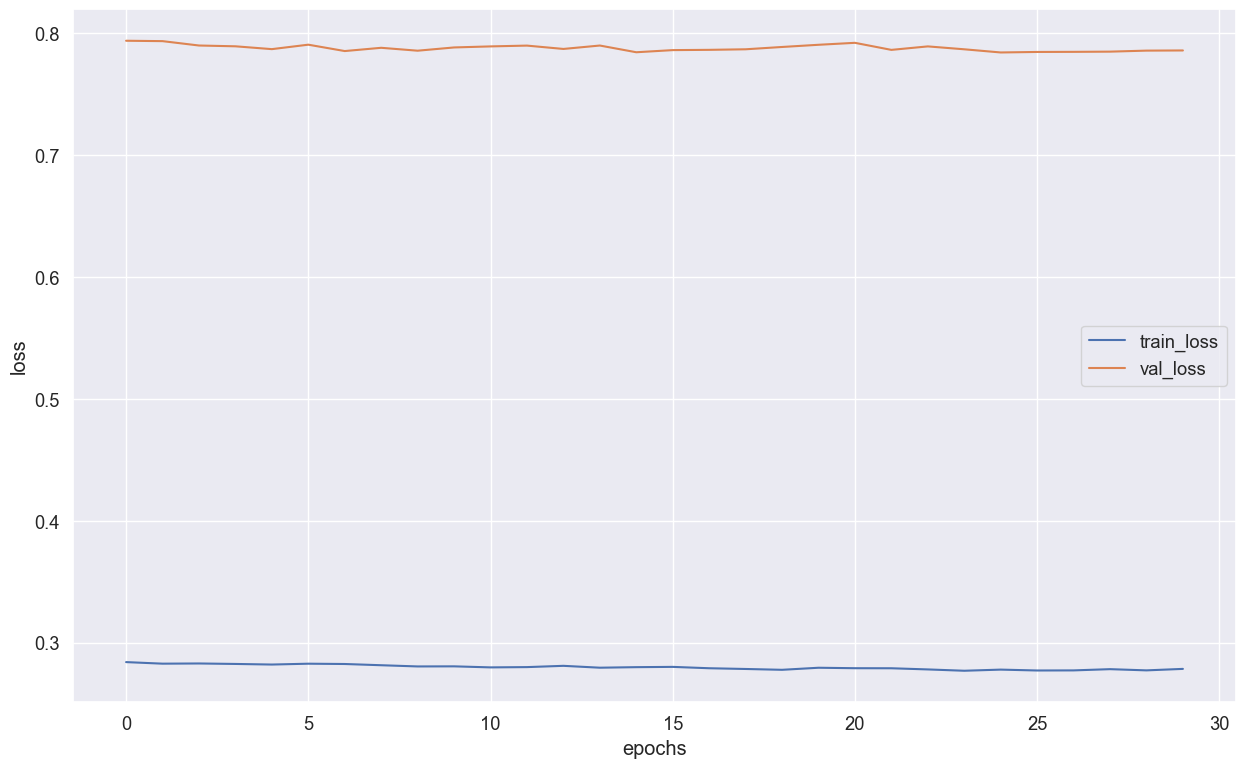

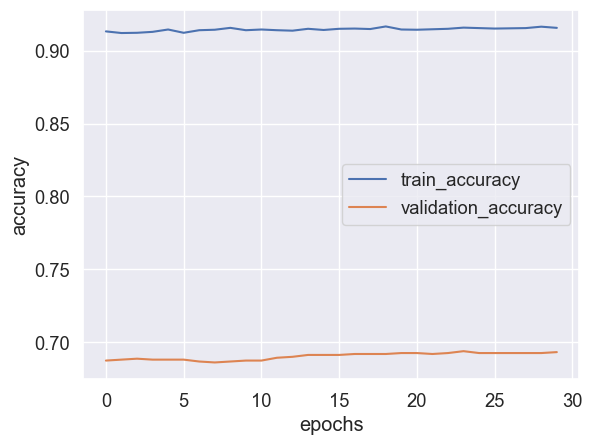

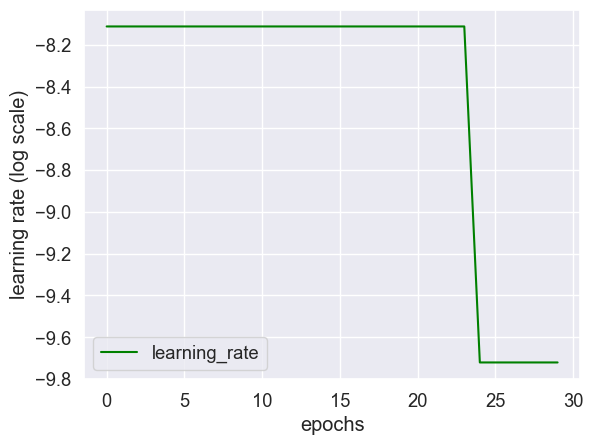

In [356]:
vizualize(graphs, 'RuBert')

In [357]:
tbert = TransformerRegrModel('rubert', 2)
model_path = "tiny.pt"
tbert.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tbert.to(device)
tbert.eval()
result = predict(tbert, valid_dataloader_ru)

In [375]:
len(result[1])

1552

In [358]:
CLASSES = {'low': 0,
           'high': 1
}

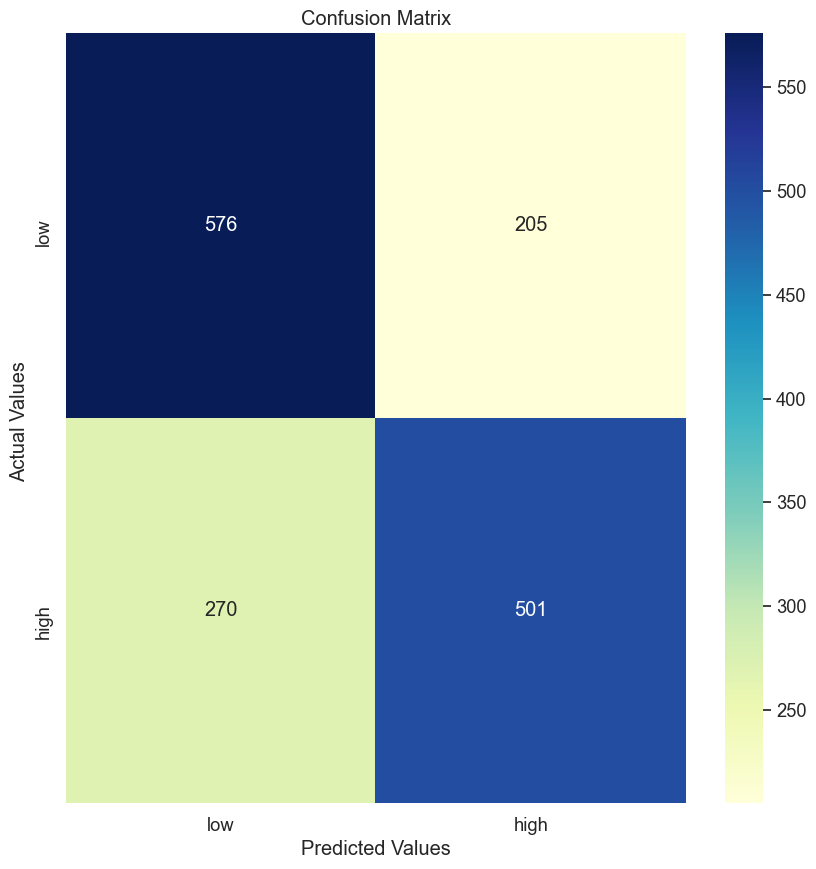

In [359]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(list(CLASSES.keys()))
ax.yaxis.set_ticklabels(list(CLASSES.keys()))
plt.show()

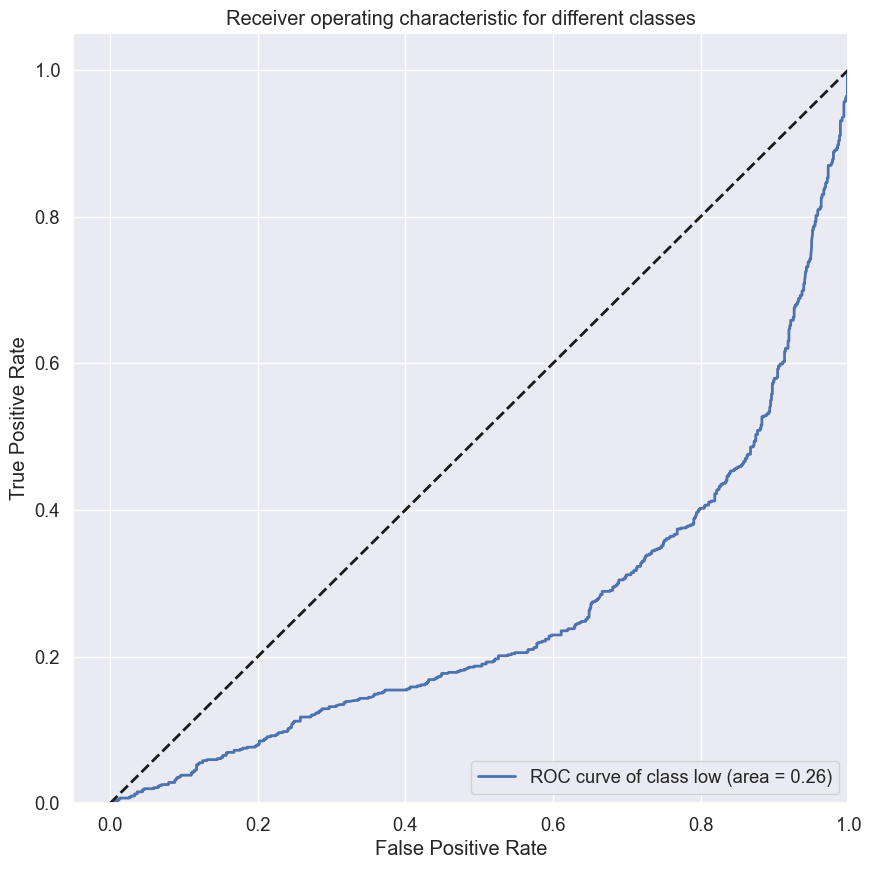

In [360]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

In [369]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

tensor([[-1.3003,  1.1920],
        [ 1.1854, -1.3319],
        [-1.3126,  1.2045],
        [-1.3021,  1.1942],
        [-1.3003,  1.1920],
        [ 1.1922, -1.3393],
        [ 1.1862, -1.3338],
        [-1.3112,  1.2033],
        [ 1.1892, -1.3374],
        [-1.2944,  1.1871],
        [-1.3060,  1.1984],
        [ 1.1914, -1.3367],
        [ 1.1945, -1.3335],
        [ 1.1870, -1.3333],
        [ 1.2009, -1.3465],
        [ 1.1848, -1.3318],
        [-1.3129,  1.2051],
        [ 1.1858, -1.3322],
        [ 1.2125, -1.3567],
        [-1.3046,  1.1972],
        [ 1.1966, -1.3430],
        [ 1.1922, -1.3375],
        [-1.3130,  1.2050],
        [-1.3145,  1.2065],
        [ 0.2398, -0.3736],
        [-1.3102,  1.2022],
        [ 1.1882, -1.3347],
        [ 1.1865, -1.3328],
        [ 1.1846, -1.3311],
        [ 1.1991, -1.3455],
        [ 1.1865, -1.3331],
        [-1.3050,  1.1967],
        [ 1.1839, -1.3301],
        [-1.3116,  1.2036],
        [ 1.1921, -1.3384],
        [-1.3076,  1

### Torch 30 эпох freeze

In [376]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=30,
                                                                rate=lr, criterion=bce, freeze=True)

epoch:   3%|██▌                                                                         | 1/30 [00:15<07:32, 15.61s/it]


Epoch 001 train_loss: 0.2772     val_loss 0.7878 train_acc 0.9151 val_acc 0.6927, learning rate 0.0003


epoch:   7%|█████                                                                       | 2/30 [00:32<07:30, 16.11s/it]

save best model for 1 epoch

Epoch 002 train_loss: 0.2769     val_loss 0.7893 train_acc 0.9162 val_acc 0.6933, learning rate 0.0003


epoch:  10%|███████▌                                                                    | 3/30 [00:48<07:19, 16.26s/it]


Epoch 003 train_loss: 0.2771     val_loss 0.7887 train_acc 0.9164 val_acc 0.6933, learning rate 0.0003


epoch:  13%|██████████▏                                                                 | 4/30 [01:04<07:02, 16.24s/it]


Epoch 004 train_loss: 0.2787     val_loss 0.7841 train_acc 0.9153 val_acc 0.6927, learning rate 0.0003


epoch:  17%|████████████▋                                                               | 5/30 [01:21<06:49, 16.39s/it]

save best model for 4 epoch

Epoch 005 train_loss: 0.2778     val_loss 0.7850 train_acc 0.9161 val_acc 0.6939, learning rate 0.0003


epoch:  20%|███████████████▏                                                            | 6/30 [01:37<06:32, 16.37s/it]


Epoch 006 train_loss: 0.2767     val_loss 0.7877 train_acc 0.9154 val_acc 0.6933, learning rate 0.0003


epoch:  23%|█████████████████▋                                                          | 7/30 [01:54<06:22, 16.62s/it]


Epoch 007 train_loss: 0.2770     val_loss 0.7878 train_acc 0.9161 val_acc 0.6933, learning rate 0.0003


epoch:  27%|████████████████████▎                                                       | 8/30 [02:12<06:12, 16.91s/it]


Epoch 008 train_loss: 0.2769     val_loss 0.7844 train_acc 0.9166 val_acc 0.6939, learning rate 0.0003


epoch:  30%|██████████████████████▊                                                     | 9/30 [02:29<05:53, 16.85s/it]


Epoch 009 train_loss: 0.2773     val_loss 0.7854 train_acc 0.9162 val_acc 0.6933, learning rate 0.0003


epoch:  33%|█████████████████████████                                                  | 10/30 [02:44<05:30, 16.50s/it]


Epoch 010 train_loss: 0.2767     val_loss 0.7818 train_acc 0.9149 val_acc 0.6933, learning rate 0.0003


epoch:  37%|███████████████████████████▍                                               | 11/30 [03:01<05:14, 16.54s/it]


Epoch 011 train_loss: 0.2760     val_loss 0.7839 train_acc 0.9166 val_acc 0.6933, learning rate 0.0003


epoch:  40%|██████████████████████████████                                             | 12/30 [03:16<04:52, 16.24s/it]


Epoch 012 train_loss: 0.2766     val_loss 0.7840 train_acc 0.9167 val_acc 0.6933, learning rate 0.0003


epoch:  43%|████████████████████████████████▌                                          | 13/30 [03:33<04:39, 16.41s/it]


Epoch 013 train_loss: 0.2764     val_loss 0.7858 train_acc 0.9164 val_acc 0.6933, learning rate 0.0003


epoch:  47%|███████████████████████████████████                                        | 14/30 [03:50<04:24, 16.55s/it]


Epoch 014 train_loss: 0.2765     val_loss 0.7896 train_acc 0.9162 val_acc 0.6933, learning rate 0.0003


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [04:06<04:05, 16.39s/it]


Epoch 015 train_loss: 0.2755     val_loss 0.7872 train_acc 0.9174 val_acc 0.6933, learning rate 0.0003


epoch:  53%|████████████████████████████████████████                                   | 16/30 [04:24<03:55, 16.84s/it]


Epoch 016 train_loss: 0.2753     val_loss 0.7875 train_acc 0.9159 val_acc 0.6933, learning rate 0.0003


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [04:41<03:39, 16.86s/it]


Epoch 017 train_loss: 0.2762     val_loss 0.7855 train_acc 0.9162 val_acc 0.6933, learning rate 0.0003


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [04:57<03:18, 16.57s/it]


Epoch 018 train_loss: 0.2770     val_loss 0.7871 train_acc 0.9164 val_acc 0.6933, learning rate 0.0003


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [05:13<02:59, 16.30s/it]


Epoch 019 train_loss: 0.2752     val_loss 0.7868 train_acc 0.9172 val_acc 0.6920, learning rate 0.0003


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [05:28<02:40, 16.06s/it]


Epoch 020 train_loss: 0.2749     val_loss 0.7863 train_acc 0.9170 val_acc 0.6920, learning rate 0.0003


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [05:44<02:24, 16.05s/it]


Epoch 021 train_loss: 0.2764     val_loss 0.7863 train_acc 0.9162 val_acc 0.6933, learning rate 0.0003


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [06:00<02:08, 16.11s/it]


Epoch 022 train_loss: 0.2755     val_loss 0.7870 train_acc 0.9169 val_acc 0.6927, learning rate 0.0003


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [06:16<01:51, 15.96s/it]


Epoch 023 train_loss: 0.2752     val_loss 0.7877 train_acc 0.9164 val_acc 0.6927, learning rate 0.0003


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [06:31<01:35, 15.84s/it]


Epoch 024 train_loss: 0.2753     val_loss 0.7857 train_acc 0.9159 val_acc 0.6939, learning rate 0.0003


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [06:47<01:18, 15.78s/it]


Epoch 025 train_loss: 0.2763     val_loss 0.7894 train_acc 0.9167 val_acc 0.6939, learning rate 5.9999999999999995e-05


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [07:04<01:03, 15.99s/it]

save best model for 25 epoch

Epoch 026 train_loss: 0.2764     val_loss 0.7893 train_acc 0.9162 val_acc 0.6946, learning rate 5.9999999999999995e-05


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [07:19<00:47, 15.85s/it]


Epoch 027 train_loss: 0.2754     val_loss 0.7888 train_acc 0.9156 val_acc 0.6946, learning rate 5.9999999999999995e-05


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [07:35<00:31, 15.73s/it]


Epoch 028 train_loss: 0.2737     val_loss 0.7896 train_acc 0.9177 val_acc 0.6946, learning rate 5.9999999999999995e-05


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [07:50<00:15, 15.68s/it]


Epoch 029 train_loss: 0.2744     val_loss 0.7897 train_acc 0.9166 val_acc 0.6946, learning rate 5.9999999999999995e-05


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [08:06<00:00, 16.21s/it]


Epoch 030 train_loss: 0.2758     val_loss 0.7890 train_acc 0.9169 val_acc 0.6939, learning rate 5.9999999999999995e-05


### Torch 100 эпох

In [377]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=100,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:   1%|▊                                                                          | 1/100 [00:16<27:41, 16.79s/it]


Epoch 001 train_loss: 0.2756     val_loss 0.7851 train_acc 0.9172 val_acc 0.6933, learning rate 0.0003


epoch:   2%|█▌                                                                         | 2/100 [00:33<26:55, 16.48s/it]

save best model for 1 epoch

Epoch 002 train_loss: 0.2737     val_loss 0.7864 train_acc 0.9174 val_acc 0.6933, learning rate 0.0003


epoch:   3%|██▎                                                                        | 3/100 [00:49<26:33, 16.43s/it]


Epoch 003 train_loss: 0.2743     val_loss 0.7858 train_acc 0.9177 val_acc 0.6933, learning rate 0.0003


epoch:   4%|███                                                                        | 4/100 [01:05<25:47, 16.12s/it]


Epoch 004 train_loss: 0.2750     val_loss 0.7871 train_acc 0.9172 val_acc 0.6933, learning rate 0.0003


epoch:   5%|███▊                                                                       | 5/100 [01:20<25:11, 15.91s/it]


Epoch 005 train_loss: 0.2751     val_loss 0.7887 train_acc 0.9172 val_acc 0.6933, learning rate 0.0003


epoch:   6%|████▌                                                                      | 6/100 [01:36<25:04, 16.01s/it]

save best model for 5 epoch

Epoch 006 train_loss: 0.2748     val_loss 0.7857 train_acc 0.9170 val_acc 0.6939, learning rate 0.0003


epoch:   7%|█████▎                                                                     | 7/100 [01:52<24:37, 15.89s/it]


Epoch 007 train_loss: 0.2763     val_loss 0.7866 train_acc 0.9170 val_acc 0.6939, learning rate 0.0003


epoch:   8%|██████                                                                     | 8/100 [02:08<24:17, 15.84s/it]


Epoch 008 train_loss: 0.2759     val_loss 0.7872 train_acc 0.9164 val_acc 0.6939, learning rate 0.0003


epoch:   9%|██████▊                                                                    | 9/100 [02:24<24:02, 15.85s/it]

save best model for 8 epoch

Epoch 009 train_loss: 0.2756     val_loss 0.7876 train_acc 0.9172 val_acc 0.6946, learning rate 0.0003


epoch:  10%|███████▍                                                                  | 10/100 [02:40<24:01, 16.02s/it]

save best model for 9 epoch

Epoch 010 train_loss: 0.2753     val_loss 0.7884 train_acc 0.9159 val_acc 0.6952, learning rate 0.0003


epoch:  11%|████████▏                                                                 | 11/100 [02:56<23:37, 15.92s/it]


Epoch 011 train_loss: 0.2744     val_loss 0.7902 train_acc 0.9174 val_acc 0.6946, learning rate 0.0003


epoch:  12%|████████▉                                                                 | 12/100 [03:11<23:16, 15.87s/it]


Epoch 012 train_loss: 0.2750     val_loss 0.7879 train_acc 0.9170 val_acc 0.6952, learning rate 0.0003


epoch:  13%|█████████▌                                                                | 13/100 [03:27<22:50, 15.76s/it]


Epoch 013 train_loss: 0.2748     val_loss 0.7913 train_acc 0.9166 val_acc 0.6952, learning rate 0.0003


epoch:  14%|██████████▎                                                               | 14/100 [03:43<22:41, 15.83s/it]


Epoch 014 train_loss: 0.2747     val_loss 0.7892 train_acc 0.9162 val_acc 0.6952, learning rate 0.0003


epoch:  15%|███████████                                                               | 15/100 [03:59<22:23, 15.81s/it]


Epoch 015 train_loss: 0.2749     val_loss 0.7864 train_acc 0.9167 val_acc 0.6952, learning rate 0.0003


epoch:  16%|███████████▊                                                              | 16/100 [04:17<23:07, 16.52s/it]

save best model for 15 epoch

Epoch 016 train_loss: 0.2746     val_loss 0.7866 train_acc 0.9167 val_acc 0.6959, learning rate 0.0003


epoch:  17%|████████████▌                                                             | 17/100 [04:33<22:33, 16.31s/it]


Epoch 017 train_loss: 0.2747     val_loss 0.7895 train_acc 0.9172 val_acc 0.6959, learning rate 0.0003


epoch:  18%|█████████████▎                                                            | 18/100 [04:49<22:11, 16.24s/it]


Epoch 018 train_loss: 0.2759     val_loss 0.7886 train_acc 0.9162 val_acc 0.6959, learning rate 0.0003


epoch:  19%|██████████████                                                            | 19/100 [05:05<21:48, 16.16s/it]


Epoch 019 train_loss: 0.2752     val_loss 0.7908 train_acc 0.9154 val_acc 0.6959, learning rate 0.0003


epoch:  20%|██████████████▊                                                           | 20/100 [05:20<21:18, 15.98s/it]


Epoch 020 train_loss: 0.2741     val_loss 0.7899 train_acc 0.9174 val_acc 0.6959, learning rate 0.0003


epoch:  21%|███████████████▌                                                          | 21/100 [05:36<21:04, 16.01s/it]


Epoch 021 train_loss: 0.2757     val_loss 0.7880 train_acc 0.9167 val_acc 0.6959, learning rate 0.0003


epoch:  22%|████████████████▎                                                         | 22/100 [05:52<20:40, 15.91s/it]


Epoch 022 train_loss: 0.2741     val_loss 0.7903 train_acc 0.9174 val_acc 0.6952, learning rate 0.0003


epoch:  23%|█████████████████                                                         | 23/100 [06:08<20:16, 15.80s/it]


Epoch 023 train_loss: 0.2748     val_loss 0.7868 train_acc 0.9170 val_acc 0.6959, learning rate 0.0003


epoch:  24%|█████████████████▊                                                        | 24/100 [06:23<19:56, 15.75s/it]


Epoch 024 train_loss: 0.2729     val_loss 0.7918 train_acc 0.9169 val_acc 0.6952, learning rate 0.0003


epoch:  25%|██████████████████▌                                                       | 25/100 [06:39<19:41, 15.76s/it]


Epoch 025 train_loss: 0.2749     val_loss 0.7899 train_acc 0.9159 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  26%|███████████████████▏                                                      | 26/100 [06:54<19:20, 15.68s/it]


Epoch 026 train_loss: 0.2737     val_loss 0.7899 train_acc 0.9175 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  27%|███████████████████▉                                                      | 27/100 [07:10<19:02, 15.65s/it]


Epoch 027 train_loss: 0.2726     val_loss 0.7902 train_acc 0.9167 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  28%|████████████████████▋                                                     | 28/100 [07:27<19:07, 15.94s/it]


Epoch 028 train_loss: 0.2736     val_loss 0.7891 train_acc 0.9175 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  29%|█████████████████████▍                                                    | 29/100 [07:43<18:52, 15.95s/it]


Epoch 029 train_loss: 0.2745     val_loss 0.7894 train_acc 0.9167 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  30%|██████████████████████▏                                                   | 30/100 [07:58<18:33, 15.91s/it]


Epoch 030 train_loss: 0.2731     val_loss 0.7895 train_acc 0.9177 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  31%|██████████████████████▉                                                   | 31/100 [08:14<18:11, 15.82s/it]


Epoch 031 train_loss: 0.2745     val_loss 0.7899 train_acc 0.9170 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  32%|███████████████████████▋                                                  | 32/100 [08:30<17:53, 15.79s/it]


Epoch 032 train_loss: 0.2748     val_loss 0.7898 train_acc 0.9164 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  33%|████████████████████████▍                                                 | 33/100 [08:45<17:36, 15.77s/it]


Epoch 033 train_loss: 0.2735     val_loss 0.7888 train_acc 0.9177 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  34%|█████████████████████████▏                                                | 34/100 [09:01<17:20, 15.77s/it]


Epoch 034 train_loss: 0.2723     val_loss 0.7897 train_acc 0.9183 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  35%|█████████████████████████▉                                                | 35/100 [09:17<17:03, 15.75s/it]


Epoch 035 train_loss: 0.2719     val_loss 0.7904 train_acc 0.9183 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  36%|██████████████████████████▋                                               | 36/100 [09:33<16:46, 15.73s/it]


Epoch 036 train_loss: 0.2736     val_loss 0.7911 train_acc 0.9175 val_acc 0.6959, learning rate 5.9999999999999995e-05


epoch:  37%|███████████████████████████▍                                              | 37/100 [09:48<16:29, 15.71s/it]


Epoch 037 train_loss: 0.2738     val_loss 0.7913 train_acc 0.9170 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  38%|████████████████████████████                                              | 38/100 [10:04<16:10, 15.66s/it]


Epoch 038 train_loss: 0.2743     val_loss 0.7910 train_acc 0.9174 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  39%|████████████████████████████▊                                             | 39/100 [10:19<15:52, 15.61s/it]


Epoch 039 train_loss: 0.2726     val_loss 0.7914 train_acc 0.9170 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  40%|█████████████████████████████▌                                            | 40/100 [10:35<15:40, 15.68s/it]


Epoch 040 train_loss: 0.2739     val_loss 0.7907 train_acc 0.9178 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  41%|██████████████████████████████▎                                           | 41/100 [10:51<15:26, 15.70s/it]


Epoch 041 train_loss: 0.2734     val_loss 0.7912 train_acc 0.9162 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  42%|███████████████████████████████                                           | 42/100 [11:07<15:10, 15.69s/it]


Epoch 042 train_loss: 0.2738     val_loss 0.7915 train_acc 0.9164 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  43%|███████████████████████████████▊                                          | 43/100 [11:22<14:53, 15.68s/it]


Epoch 043 train_loss: 0.2725     val_loss 0.7911 train_acc 0.9174 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  44%|████████████████████████████████▌                                         | 44/100 [11:38<14:41, 15.75s/it]


Epoch 044 train_loss: 0.2738     val_loss 0.7915 train_acc 0.9172 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  45%|█████████████████████████████████▎                                        | 45/100 [11:54<14:29, 15.81s/it]


Epoch 045 train_loss: 0.2733     val_loss 0.7913 train_acc 0.9175 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  46%|██████████████████████████████████                                        | 46/100 [12:10<14:15, 15.85s/it]


Epoch 046 train_loss: 0.2754     val_loss 0.7918 train_acc 0.9161 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  47%|██████████████████████████████████▊                                       | 47/100 [12:26<13:55, 15.76s/it]


Epoch 047 train_loss: 0.2739     val_loss 0.7919 train_acc 0.9172 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  48%|███████████████████████████████████▌                                      | 48/100 [12:42<13:45, 15.87s/it]


Epoch 048 train_loss: 0.2738     val_loss 0.7924 train_acc 0.9167 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  49%|████████████████████████████████████▎                                     | 49/100 [12:58<13:29, 15.87s/it]


Epoch 049 train_loss: 0.2733     val_loss 0.7913 train_acc 0.9172 val_acc 0.6952, learning rate 5.9999999999999995e-05


epoch:  50%|█████████████████████████████████████                                     | 50/100 [13:13<13:08, 15.77s/it]


Epoch 050 train_loss: 0.2736     val_loss 0.7912 train_acc 0.9175 val_acc 0.6952, learning rate 1.2e-05


epoch:  51%|█████████████████████████████████████▋                                    | 51/100 [13:29<12:49, 15.70s/it]


Epoch 051 train_loss: 0.2727     val_loss 0.7910 train_acc 0.9174 val_acc 0.6952, learning rate 1.2e-05


epoch:  52%|██████████████████████████████████████▍                                   | 52/100 [13:44<12:35, 15.74s/it]


Epoch 052 train_loss: 0.2751     val_loss 0.7910 train_acc 0.9162 val_acc 0.6952, learning rate 1.2e-05


epoch:  53%|███████████████████████████████████████▏                                  | 53/100 [14:00<12:13, 15.61s/it]


Epoch 053 train_loss: 0.2727     val_loss 0.7911 train_acc 0.9187 val_acc 0.6952, learning rate 1.2e-05


epoch:  54%|███████████████████████████████████████▉                                  | 54/100 [14:15<11:56, 15.58s/it]


Epoch 054 train_loss: 0.2751     val_loss 0.7911 train_acc 0.9167 val_acc 0.6952, learning rate 1.2e-05


epoch:  55%|████████████████████████████████████████▋                                 | 55/100 [14:31<11:44, 15.66s/it]


Epoch 055 train_loss: 0.2722     val_loss 0.7912 train_acc 0.9174 val_acc 0.6952, learning rate 1.2e-05


epoch:  56%|█████████████████████████████████████████▍                                | 56/100 [14:47<11:34, 15.78s/it]


Epoch 056 train_loss: 0.2730     val_loss 0.7913 train_acc 0.9172 val_acc 0.6952, learning rate 1.2e-05


epoch:  57%|██████████████████████████████████████████▏                               | 57/100 [15:03<11:14, 15.68s/it]


Epoch 057 train_loss: 0.2741     val_loss 0.7911 train_acc 0.9166 val_acc 0.6952, learning rate 1.2e-05


epoch:  58%|██████████████████████████████████████████▉                               | 58/100 [15:18<10:58, 15.67s/it]


Epoch 058 train_loss: 0.2748     val_loss 0.7911 train_acc 0.9170 val_acc 0.6952, learning rate 1.2e-05


epoch:  59%|███████████████████████████████████████████▋                              | 59/100 [15:34<10:42, 15.67s/it]


Epoch 059 train_loss: 0.2742     val_loss 0.7911 train_acc 0.9167 val_acc 0.6952, learning rate 1.2e-05


epoch:  60%|████████████████████████████████████████████▍                             | 60/100 [15:50<10:27, 15.68s/it]


Epoch 060 train_loss: 0.2739     val_loss 0.7910 train_acc 0.9167 val_acc 0.6952, learning rate 1.2e-05


epoch:  61%|█████████████████████████████████████████████▏                            | 61/100 [16:05<10:12, 15.70s/it]


Epoch 061 train_loss: 0.2719     val_loss 0.7911 train_acc 0.9185 val_acc 0.6952, learning rate 1.2e-05


epoch:  62%|█████████████████████████████████████████████▉                            | 62/100 [16:21<09:55, 15.66s/it]


Epoch 062 train_loss: 0.2736     val_loss 0.7910 train_acc 0.9174 val_acc 0.6952, learning rate 1.2e-05


epoch:  63%|██████████████████████████████████████████████▌                           | 63/100 [16:37<09:46, 15.86s/it]


Epoch 063 train_loss: 0.2748     val_loss 0.7911 train_acc 0.9169 val_acc 0.6952, learning rate 1.2e-05


epoch:  64%|███████████████████████████████████████████████▎                          | 64/100 [16:53<09:30, 15.84s/it]


Epoch 064 train_loss: 0.2724     val_loss 0.7909 train_acc 0.9178 val_acc 0.6952, learning rate 1.2e-05


epoch:  65%|████████████████████████████████████████████████                          | 65/100 [17:09<09:11, 15.75s/it]


Epoch 065 train_loss: 0.2735     val_loss 0.7910 train_acc 0.9174 val_acc 0.6952, learning rate 1.2e-05


epoch:  66%|████████████████████████████████████████████████▊                         | 66/100 [17:24<08:53, 15.70s/it]


Epoch 066 train_loss: 0.2748     val_loss 0.7910 train_acc 0.9161 val_acc 0.6952, learning rate 1.2e-05


epoch:  67%|█████████████████████████████████████████████████▌                        | 67/100 [17:40<08:40, 15.77s/it]


Epoch 067 train_loss: 0.2741     val_loss 0.7910 train_acc 0.9162 val_acc 0.6952, learning rate 1.2e-05


epoch:  68%|██████████████████████████████████████████████████▎                       | 68/100 [17:56<08:24, 15.76s/it]


Epoch 068 train_loss: 0.2750     val_loss 0.7910 train_acc 0.9164 val_acc 0.6952, learning rate 1.2e-05


epoch:  69%|███████████████████████████████████████████████████                       | 69/100 [18:11<08:06, 15.70s/it]


Epoch 069 train_loss: 0.2738     val_loss 0.7910 train_acc 0.9178 val_acc 0.6952, learning rate 1.2e-05


epoch:  70%|███████████████████████████████████████████████████▊                      | 70/100 [18:27<07:49, 15.65s/it]


Epoch 070 train_loss: 0.2727     val_loss 0.7911 train_acc 0.9169 val_acc 0.6952, learning rate 1.2e-05


epoch:  71%|████████████████████████████████████████████████████▌                     | 71/100 [18:43<07:35, 15.70s/it]


Epoch 071 train_loss: 0.2743     val_loss 0.7911 train_acc 0.9167 val_acc 0.6952, learning rate 1.2e-05


epoch:  72%|█████████████████████████████████████████████████████▎                    | 72/100 [18:58<07:17, 15.63s/it]


Epoch 072 train_loss: 0.2733     val_loss 0.7912 train_acc 0.9164 val_acc 0.6952, learning rate 1.2e-05


epoch:  73%|██████████████████████████████████████████████████████                    | 73/100 [19:14<07:02, 15.63s/it]


Epoch 073 train_loss: 0.2720     val_loss 0.7911 train_acc 0.9178 val_acc 0.6952, learning rate 1.2e-05


epoch:  74%|██████████████████████████████████████████████████████▊                   | 74/100 [19:30<06:46, 15.62s/it]


Epoch 074 train_loss: 0.2744     val_loss 0.7911 train_acc 0.9170 val_acc 0.6952, learning rate 1.2e-05


epoch:  75%|███████████████████████████████████████████████████████▌                  | 75/100 [19:45<06:31, 15.68s/it]


Epoch 075 train_loss: 0.2734     val_loss 0.7911 train_acc 0.9174 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  76%|████████████████████████████████████████████████████████▏                 | 76/100 [20:01<06:19, 15.80s/it]


Epoch 076 train_loss: 0.2750     val_loss 0.7911 train_acc 0.9166 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  77%|████████████████████████████████████████████████████████▉                 | 77/100 [20:17<06:03, 15.79s/it]


Epoch 077 train_loss: 0.2738     val_loss 0.7912 train_acc 0.9174 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  78%|█████████████████████████████████████████████████████████▋                | 78/100 [20:33<05:47, 15.81s/it]


Epoch 078 train_loss: 0.2734     val_loss 0.7911 train_acc 0.9162 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  79%|██████████████████████████████████████████████████████████▍               | 79/100 [20:49<05:32, 15.81s/it]


Epoch 079 train_loss: 0.2746     val_loss 0.7912 train_acc 0.9167 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  80%|███████████████████████████████████████████████████████████▏              | 80/100 [21:05<05:15, 15.77s/it]


Epoch 080 train_loss: 0.2726     val_loss 0.7912 train_acc 0.9183 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  81%|███████████████████████████████████████████████████████████▉              | 81/100 [21:20<04:58, 15.70s/it]


Epoch 081 train_loss: 0.2744     val_loss 0.7911 train_acc 0.9164 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  82%|████████████████████████████████████████████████████████████▋             | 82/100 [21:36<04:44, 15.80s/it]


Epoch 082 train_loss: 0.2723     val_loss 0.7911 train_acc 0.9175 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  83%|█████████████████████████████████████████████████████████████▍            | 83/100 [21:52<04:27, 15.75s/it]


Epoch 083 train_loss: 0.2744     val_loss 0.7911 train_acc 0.9169 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  84%|██████████████████████████████████████████████████████████████▏           | 84/100 [22:07<04:10, 15.68s/it]


Epoch 084 train_loss: 0.2729     val_loss 0.7911 train_acc 0.9180 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  85%|██████████████████████████████████████████████████████████████▉           | 85/100 [22:23<03:54, 15.65s/it]


Epoch 085 train_loss: 0.2725     val_loss 0.7912 train_acc 0.9170 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  86%|███████████████████████████████████████████████████████████████▋          | 86/100 [22:39<03:40, 15.73s/it]


Epoch 086 train_loss: 0.2733     val_loss 0.7912 train_acc 0.9169 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  87%|████████████████████████████████████████████████████████████████▍         | 87/100 [22:54<03:23, 15.69s/it]


Epoch 087 train_loss: 0.2736     val_loss 0.7912 train_acc 0.9175 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  88%|█████████████████████████████████████████████████████████████████         | 88/100 [23:11<03:11, 16.00s/it]


Epoch 088 train_loss: 0.2728     val_loss 0.7912 train_acc 0.9169 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  89%|█████████████████████████████████████████████████████████████████▊        | 89/100 [23:27<02:55, 15.94s/it]


Epoch 089 train_loss: 0.2729     val_loss 0.7912 train_acc 0.9177 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 90/100 [23:43<02:39, 15.94s/it]


Epoch 090 train_loss: 0.2747     val_loss 0.7912 train_acc 0.9167 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  91%|███████████████████████████████████████████████████████████████████▎      | 91/100 [23:58<02:22, 15.79s/it]


Epoch 091 train_loss: 0.2751     val_loss 0.7912 train_acc 0.9162 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  92%|████████████████████████████████████████████████████████████████████      | 92/100 [24:14<02:05, 15.74s/it]


Epoch 092 train_loss: 0.2748     val_loss 0.7912 train_acc 0.9162 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  93%|████████████████████████████████████████████████████████████████████▊     | 93/100 [24:30<01:50, 15.75s/it]


Epoch 093 train_loss: 0.2735     val_loss 0.7912 train_acc 0.9177 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  94%|█████████████████████████████████████████████████████████████████████▌    | 94/100 [24:45<01:34, 15.77s/it]


Epoch 094 train_loss: 0.2734     val_loss 0.7912 train_acc 0.9167 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  95%|██████████████████████████████████████████████████████████████████████▎   | 95/100 [25:01<01:18, 15.75s/it]


Epoch 095 train_loss: 0.2730     val_loss 0.7912 train_acc 0.9177 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  96%|███████████████████████████████████████████████████████████████████████   | 96/100 [25:17<01:02, 15.70s/it]


Epoch 096 train_loss: 0.2750     val_loss 0.7912 train_acc 0.9170 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  97%|███████████████████████████████████████████████████████████████████████▊  | 97/100 [25:33<00:47, 15.74s/it]


Epoch 097 train_loss: 0.2737     val_loss 0.7912 train_acc 0.9167 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  98%|████████████████████████████████████████████████████████████████████████▌ | 98/100 [25:48<00:31, 15.78s/it]


Epoch 098 train_loss: 0.2740     val_loss 0.7912 train_acc 0.9174 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch:  99%|█████████████████████████████████████████████████████████████████████████▎| 99/100 [26:04<00:15, 15.71s/it]


Epoch 099 train_loss: 0.2709     val_loss 0.7912 train_acc 0.9190 val_acc 0.6952, learning rate 2.4000000000000003e-06


epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [26:20<00:00, 15.80s/it]


Epoch 100 train_loss: 0.2729     val_loss 0.7912 train_acc 0.9178 val_acc 0.6952, learning rate 4.800000000000001e-07


Вывод: при использовании Torch и глубокое обучение для нахождении "нулевых" наблюдений промежуточная метрика для Ансамбля не превышает 0,7.

# Общий вывод

Анализ данных: На входе имеем датасет из 8708 наблюдений. Внутри есть непосредственно комментарии текстом. Теги отмеченые пользователем при комментировании - их можно будет попробывать использовать при обучении. Разметка состоит из 50 котегорий 0 и 1. Полностью нулевых разметок 4085 из 8708. Эти наблюдения будут сильно мешать обучению, но и убирать их нельзя, так как "пустые" комментарии - неотемлимая часть подобных сервисов. Некоторые тематики имеют очень мало меток: большенство до 50 шт. 46я тематека всего 7 шт. При таком соотношении я считаю, что модели при обучении мудут стремится отметить 'нули' - это видно метрике в baseline (0,500) против полностью нулевых значений (0.4691). В ходе поверхностной проверке разметка сделано адекватна. Однако мною замечены среди "нулевых" разметок информативные комментарии, которые остались без меток. Дупликатов и пропусков нет.

Обучение: 
При обучении моделей было использовано множество подходов. Хочется выделить применения Ансамля моделей.
Суть гепотезы: Необходимо проредить основной датасет с помощью модели логистической регресии для нахождение "нулевых" наблюдений. Потом учимся класически на прореженных данных. Основную метрику считаю с учетом принудительно "обнуленных" наблюдений выделенных в первом этапе.
Полученый результат: Метрика 0.50344. Есть маленкий буст.

Вывод: В проекте я сделал упор на выявления именно "нулевых" наблюдений. Считаю, что при эффективном их выявлении можно добится каких-то результатов. 

Недостатки входящих данных:
* задача на 50 тематик очень сложная для маленького несбалансированного датасета
* разметка не идеальна: среди "нулевых" разметок есть информативные комментарии

Рекомендации:
* увеличить количество наблюдений для обучения
* улучшить качество разметки
* нужен баланс между тематиками
* большенство тематик представлены в выборке в количестве до 50 наблюдений - это очень мало. 
